# BirdCLEF 2025 Data Preprocessing Notebook

This notebook demonstrates a complete pipeline for transforming raw audio into mel-spectrograms suitable for 2D CNN training:

1.  **Configuration**:
    * Toggle debug mode and set paths for input/output.
    * Define audio sampling and mel-spectrogram parameters.

2.  **Data Loading**:
    * Read taxonomy and training metadata CSVs.
    * Map species labels to integer targets.

3.  **Filepath Setup**:
    * Construct full paths to audio files.

4.  **Spectrogram Preprocessing**:
    * Precompute mel filterbank and apply STFT.
    * Handle NaNs, padding, and central cropping.
    * Normalize to [0,1] range (min-max).

5.  **Parallel Processing**:
    * Leverage Joblib to accelerate per-file mel-spectrogram generation.

6.  **Saving & Reloading**:
    * Save processed spectrograms to an NPY file (with optional `debug_` prefix).
    * Load existing data to skip recomputation.

7.  **Visualization**:
    * Display a grid of sample mel-spectrograms with class labels.

Run in debug mode for a quick sanity check or full mode for complete preprocessing.

You can find the transformed files here: [team gdrive](https://drive.google.com/drive/folders/1JQksLPcvC5lHm-OzThCz-p1bkNJYgixQ?usp=drive_link)

In [28]:
import cv2
import math
import time
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

In [29]:
class Config:
    """
    A configuration class that holds various parameters for audio processing,
    data handling, and model training/inference.

    Attributes:
        DEBUG_MODE (bool): Flag to enable or disable debug mode.
                           If True, certain operations (like data loading limits)
                           might be restricted for faster testing.
        OUTPUT_DIR (str): Path to the directory where output files (e.g., processed data,
                          model checkpoints, predictions) will be saved.
                          Two example paths are provided, commented out for typical
                          Kaggle environment vs. local setup.
        DATA_ROOT (str): Path to the root directory containing the raw input data.
                         Similar to OUTPUT_DIR, examples for Kaggle vs. local are given.
        FS (int): The target sampling rate (in Hz) for audio processing.
                  Audio will be resampled to this rate if it differs.
        N_FFT (int): The size of the Fast Fourier Transform (FFT) window.
                     Determines the frequency resolution of the spectrogram.
        HOP_LENGTH (int): The number of samples between successive frames in the spectrogram.
                          Controls the temporal resolution and overlap of windows.
        N_MELS (int): The number of Mel-frequency bins to generate in the Mel-spectrogram.
                      A higher number provides finer frequency resolution on the Mel scale.
        FMIN (float): The minimum frequency (in Hz) to consider for the Mel filterbank.
                      Frequencies below this will be ignored.
        FMAX (float): The maximum frequency (in Hz) to consider for the Mel filterbank.
                      Frequencies above this will be ignored.
        TARGET_DURATION (float): The target duration (in seconds) for audio clips.
                                 Audio shorter than this might be padded, and longer
                                 audio might be trimmed or split.
        TARGET_SHAPE (tuple[int, int]): The desired shape (height, width) for the
                                        Mel-spectrograms after any resizing or cropping.
                                        Often (n_mels, time_frames).
        N_MAX (int | None): The maximum number of items (e.g., audio files, samples)
                            to process. Used primarily in DEBUG_MODE to limit data
                            for quicker testing. If DEBUG_MODE is False, it's None,
                            meaning all available data will be processed.
    """

    DEBUG_MODE: bool = True
    
    # Save this in case we will be submitting to Kaggle
    # OUTPUT_DIR: str = '/kaggle/working/'
    # DATA_ROOT: str = '/kaggle/input/birdclef-2025'
    
    OUTPUT_DIR: str = '/dfs6/pub/ddlin/projects/mids/DATASCI207_Bird_Sounds/data/working/'
    DATA_ROOT: str = '/pub/ddlin/projects/mids/DATASCI207_Bird_Sounds/data/raw'
    
    # Audio sampling rate
    FS: int = 32000 # Samples per second (ogg audio have been resampled to 32 kHz)

    # Mel spectrogram parameters: These define how the audio will be transformed
    # into a Mel-spectrogram, which is a common feature representation for audio.
    # Specifies the window size for the FFT operation. The audio signal is divided into short, overlapping frames, and an FFT is computed for each frame.
    N_FFT: int = 1024       # Number of samples in each FFT window. Higher values mean better frequency resolution. 
    HOP_LENGTH: int = 512   # Number of samples between successive frames. Smaller values mean more overlap and higher temporal resolution.
    N_MELS: int = 128       # Number of Mel bands to generate. Corresponds to the height of the Mel-spectrogram image.
    FMIN: float = 50.0      # Minimum frequency (Hz) to consider for the Mel filterbank.
    FMAX: float = 14000.0   # Maximum frequency (Hz) to consider for the Mel filterbank.

    # Target dimensions and duration for processed audio/spectrograms.
    TARGET_DURATION: float = 5.0 # Target duration in seconds for each audio clip or segment.
    # TARGET_SHAPE: tuple[int, int] = (256, 256) # Desired (height, width) of the output spectrogram image.
    TARGET_SHAPE: tuple[int, int] = (32, 32) # Desired (height, width) of the output spectrogram image.

    # Data loading limit for debugging purposes.
    # If DEBUG_MODE is True, only process a maximum of 50 items.
    # Otherwise, process all available items (None means no limit).
    N_MAX: int | None = 1000 if DEBUG_MODE else None

config: Config = Config()

In [30]:
data_root = Path(config.DATA_ROOT)
train_audio_dir = data_root / 'train_audio'

print(f"Debug mode: {'ON' if config.DEBUG_MODE else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(data_root / 'taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(data_root / 'train.csv')

Debug mode: ON
Max samples to process: 1000
Loading taxonomy data...
Loading training metadata...


In [31]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df[['primary_label', 'rating', 'filename']].copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = working_df.filename.map(lambda fn: str(train_audio_dir / fn))
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

working_df.head()

Found 206 unique species
Total samples to process: 1000 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


,primary_label,rating,filename,target,filepath,samplename,class
0,1139490,0.0,1139490/CSA36385.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta
1,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta
2,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta
3,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta
4,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta


In [32]:
# Precompute mel filterbank once to avoid redundant work in each call
mel_basis = librosa.filters.mel(
    sr=config.FS,
    n_fft=config.N_FFT,
    n_mels=config.N_MELS,
    fmin=config.FMIN,
    fmax=config.FMAX
)

def audio2melspec(audio_data: np.ndarray) -> np.ndarray:
    """
    Converts raw audio data into a normalized Mel-spectrogram.

    This function preprocesses audio by handling NaN values, then computes
    a Mel-spectrogram, converts it to decibels, and finally normalizes
    the decibel-scaled spectrogram to a [0, 1] range.

    Args:
        audio_data (np.ndarray): A 1D NumPy array representing the raw audio
                                 time-series. Expected to be amplitude values.

    Returns:
        np.ndarray: A 2D NumPy array representing the normalized Mel-spectrogram.
                    The dimensions are (n_mels, number_of_time_frames),
                    with values scaled between 0 and 1.
    """
    # --- Handle NaN values in audio data ---
    # If any NaN values are present, replace them with the mean of the non-NaN values.
    # This prevents errors in subsequent processing steps that cannot handle NaNs.
    if np.isnan(audio_data).any():
        mean_signal: float = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    # --- Compute Mel-spectrogram ---
    # Generates a Mel-scaled spectrogram from the audio data.
    # The 'power=2.0' argument means the output represents power (squared magnitude).
    S = np.abs(librosa.stft(
        y=audio_data,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH
    ))**2
    # apply the cached mel filterbank
    mel_spec = mel_basis.dot(S)

    # --- Convert Mel-spectrogram to Decibels (dB) ---
    # Converts the power spectrogram to a decibel scale, which is more
    # perceptually relevant as human hearing is logarithmic.
    # 'ref=np.max' sets the maximum value in the spectrogram to 0 dB.
    mel_spec_db: np.ndarray = librosa.power_to_db(mel_spec, ref=np.max)

    # --- Normalize Mel-spectrogram to [0, 1] range ---
    # Performs min-max normalization to scale the decibel-scaled spectrogram
    # values to be between 0 and 1. This is beneficial for machine learning models.
    # A small epsilon (1e-8) is added to the denominator to prevent division by zero
    # if the max and min values happen to be the same (e.g., for silent audio).
    min_val: float = mel_spec_db.min()
    max_val: float = mel_spec_db.max()
    mel_spec_norm: np.ndarray = (mel_spec_db - min_val) / (max_val - min_val + 1e-8)
    
    return mel_spec_norm

In [33]:
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only ' + str(config.N_MAX) + ' samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")

start_time = time.time()

all_bird_data: dict[str, np.ndarray] = {} # Dictionary to store processed Mel-spectrograms (np.ndarray), keyed by sample name.
errors: list[tuple[str, str]] = [] # List to store any errors encountered during processing, along with their file paths.

# Ensure the output directory exists and build filename with optional debug prefix
output_dir = Path(config.OUTPUT_DIR) / 'birdclef25-mel-spectrograms'
output_dir.mkdir(parents=True, exist_ok=True)

prefix = "debug_" if config.DEBUG_MODE else ""
# filename = f"{prefix}birdclef2025_melspec_5sec_256_256.npy"
filename = f"{prefix}birdclef2025_melspec_5sec_32_32.npy"
aggregated_npy_path = output_dir / filename

working_df.to_csv(output_dir / f"{prefix}working_df.csv", index=False)

# Parallel processing of the mel-spectrogram generation
def process_row(i, row):
    # If debug mode is active and the current iteration index exceeds the N_MAX limit, break the loop.
    if config.N_MAX is not None and i >= config.N_MAX:
        return row.samplename, None

    try:
        # Load audio data using librosa.load, ensuring it's resampled to the target sampling rate (config.FS).
        # The second return value (original sampling rate) is ignored with '_'.
        audio_data: np.ndarray
        _ : float # Placeholder for the original sampling rate
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        # Calculate the target number of samples for the desired duration.
        target_samples: int = int(config.TARGET_DURATION * config.FS)

        # --- Handle audio length: Padding for short clips ---
        # If the loaded audio is shorter than the target duration:
        if len(audio_data) < target_samples:
            # Calculate how many times the audio needs to be copied to meet the target duration.
            n_copy: int = math.ceil(target_samples / len(audio_data))
            # If multiple copies are needed, concatenate the audio to itself.
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        # --- Extract central segment of audio ---
        # Calculate start and end indices to extract a segment of `target_samples` from the center of the audio.
        # `max(0, ...)` ensures the start index is not negative.
        # `min(len(audio_data), ...)` ensures the end index does not exceed the audio length.
        start_idx: int = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx: int = min(len(audio_data), start_idx + target_samples)
        center_audio: np.ndarray = audio_data[start_idx:end_idx]

        # --- Final padding if center segment is still too short ---
        # If, after central extraction, the audio is still shorter than the target, pad it with zeros.
        # This can happen if the original audio was very short and even copying didn't perfectly fill.
        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                  (0, target_samples - len(center_audio)), # Pad at the end
                                  mode='constant') # Pad with zeros

        # --- Convert audio to Mel-spectrogram ---
        # Call the helper function to convert the processed audio segment into a Mel-spectrogram.
        mel = audio2melspec(center_audio)

        # --- Resize Mel-spectrogram ---
        # If the generated Mel-spectrogram's shape doesn't match the desired target shape, resize it.
        # cv2.INTER_LINEAR is a common interpolation method for image resizing.
        if mel.shape != config.TARGET_SHAPE:
            mel = cv2.resize(mel, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        return row.samplename, mel.astype(np.float32)
        
    except Exception as e:
        # Catch any exceptions that occur during processing of a single file.
        # Print an error message and record the filepath and the error message.
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))
        return row.samplename, None

results = Parallel(n_jobs=-1)(
    delayed(process_row)(i, row)
    for i, row in tqdm(working_df.iterrows(), total=total_samples)
    if config.N_MAX is None or i < config.N_MAX
)

# collect into dictionary and record any missing entries
all_bird_data = dict(results)
# Save the entire dictionary to a single .npy file
np.save(str(aggregated_npy_path), all_bird_data, allow_pickle=True)
print(f"All spectrograms saved to: {aggregated_npy_path}")

end_time: float = time.time() # Record the end time.

# Print a summary of the processing results.
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")

Starting audio processing...
DEBUG MODE - Processing only 1000 samples


  0%|          | 0/1000 [00:00<?, ?it/s]

All spectrograms saved to: /dfs6/pub/ddlin/projects/mids/DATASCI207_Bird_Sounds/data/working/birdclef25-mel-spectrograms/debug_birdclef2025_melspec_5sec_32_32.npy
Processing completed in 4.18 seconds
Successfully processed 1000 files out of 1000 total
Failed to process 0 files


No errors encountered during processing.
Loaded existing spectrograms: 1000 samples


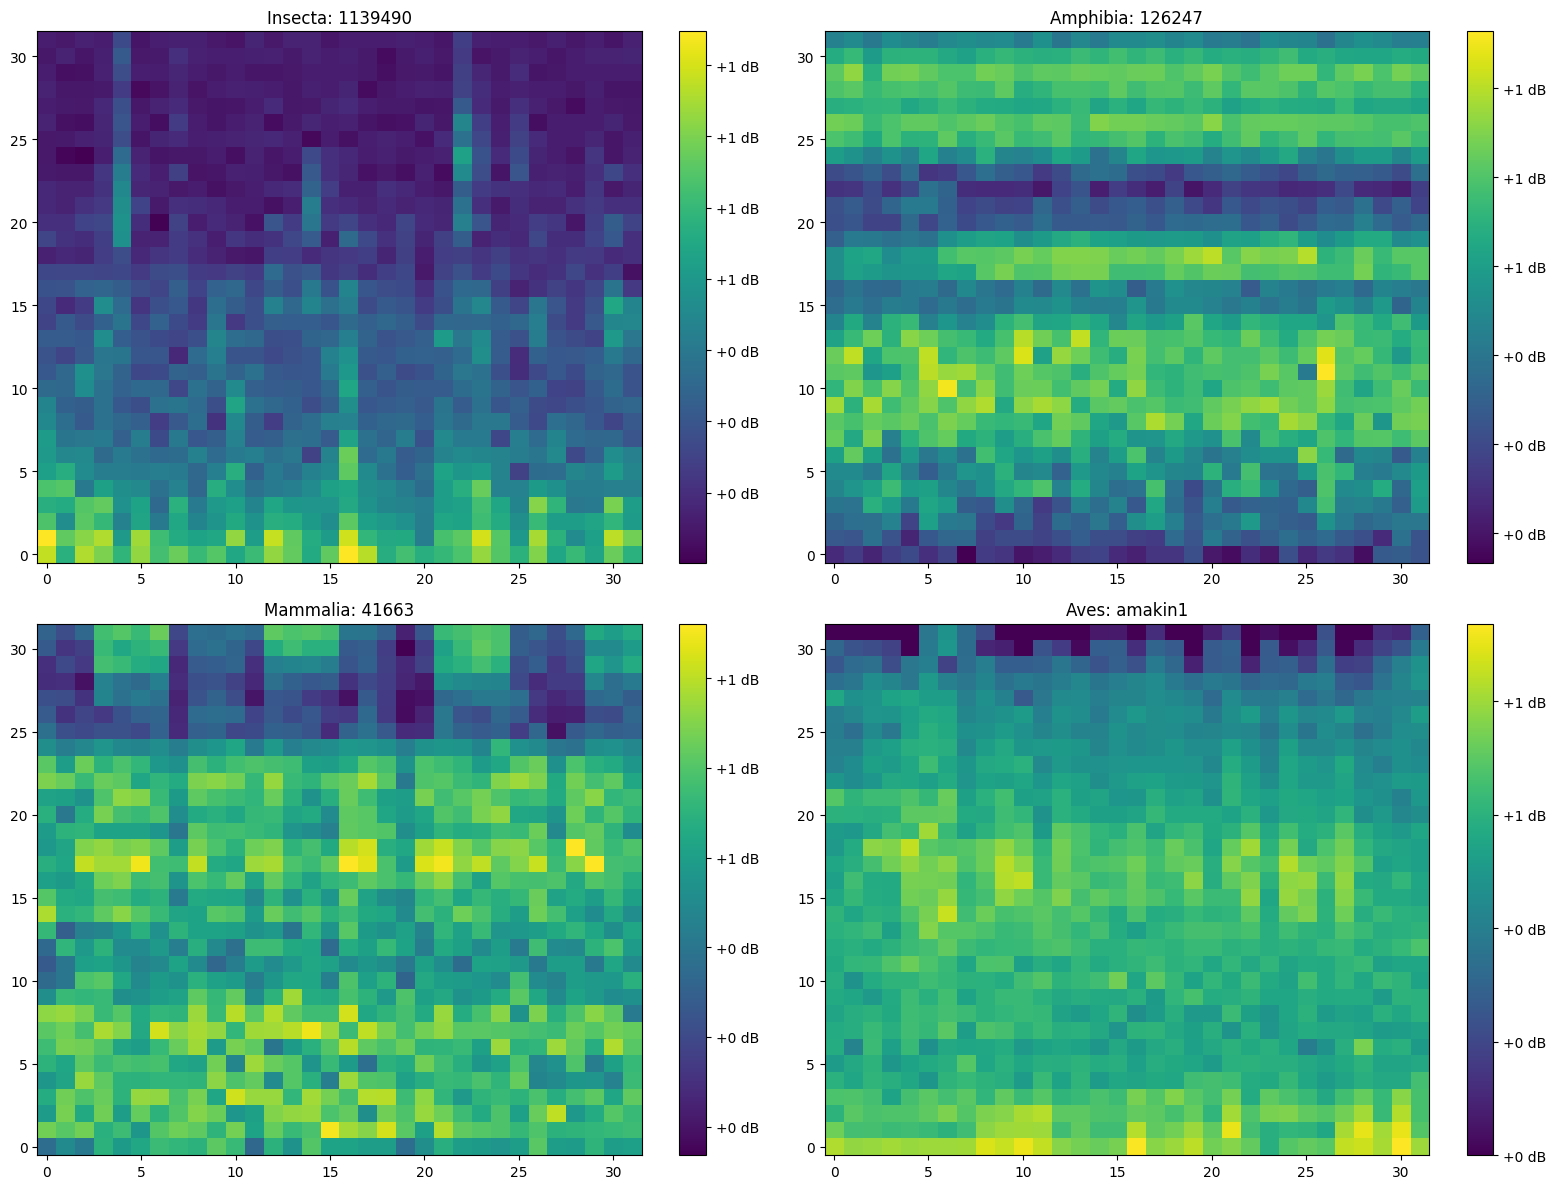

In [34]:
# Check if there were any errors during processing.
if errors:
    print("Errors encountered during processing:")
    for filepath, error in errors:
        print(f"File: {filepath}, Error: {error}")
else:
    print("No errors encountered during processing.")

# Load the aggregated .npy file if it exists, let's check the mel spectrograms.
if aggregated_npy_path.exists():
    all_bird_data = np.load(str(aggregated_npy_path), allow_pickle=True).item()
    print(f"Loaded existing spectrograms: {len(all_bird_data)} samples")

samples = []
displayed_classes = set()

# Determine the maximum number of samples to display.
# It will be the minimum of 4 or the total number of entries in 'all_bird_data'.
# This ensures that we don't try to display more than 4 plots and also
# don't exceed the available data.
max_samples = min(4, len(all_bird_data))

# Iterate through each row of the 'working_df' DataFrame.
for i, row in working_df.iterrows():
    # If the current iteration index 'i' reaches the 'N_MAX' limit from the config
    # (if 'N_MAX' is defined), or if it exceeds the total length of 'working_df',
    # then break the loop. This is a safety check to prevent processing too many rows.
    if i >= (config.N_MAX or len(working_df)):
        break
        
    # Check if the 'samplename' from the current row exists as a key in 'all_bird_data'.
    # 'all_bird_data' is expected to contain the pre-computed or generated mel spectrograms (.npy).
    if row['samplename'] in all_bird_data:
        # If in debug mode, or if not in debug mode, and the 'class' of the current sample
        # has not been displayed yet, then add this sample to the 'samples' list.
        # This ensures that unique classes are displayed.
        if config.DEBUG_MODE:
            if row['class'] not in displayed_classes:
                # Append a tuple containing samplename, class, and primary_label.
                samples.append((row['samplename'], row['class'], row['primary_label']))
                # Add the class name to the set of displayed classes to avoid duplicates.
                displayed_classes.add(row['class'])
        else:
            # This 'else' block is identical to the 'if config.DEBUG_MODE' block,
            # which might indicate redundant code or a placeholder for future
            # different non-debug behavior.
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        
        # If the number of collected samples reaches 'max_samples', break the loop.
        # This limits the total number of spectrograms to be plotted.
        if len(samples) >= max_samples: 
            break

# If there are any samples collected, proceed to plot them.
if samples:
    # Create a new figure with a specified size for plotting.
    plt.figure(figsize=(16, 12))
    
    # Iterate through the collected samples with their index.
    for i, (samplename, class_name, species) in enumerate(samples):
        # Create a subplot within the figure. The layout is 2 rows, 2 columns,
        # and 'i+1' determines the current subplot position (1-indexed).
        plt.subplot(2, 2, i+1)
        # Display the mel spectrogram image.
        # 'aspect='auto'' adjusts the aspect ratio to fill the subplot.
        # 'origin='lower'' places the (0,0) index of the image in the lower-left.
        # 'cmap='viridis'' sets the color map.
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        # Set the title of the subplot to show the class name and species.
        plt.title(f"{class_name}: {species}")
        # Add a color bar to the plot, formatted to show decibels.
        plt.colorbar(format='%+2.0f dB')
    
    # Adjust subplot parameters for a tight layout, preventing labels from overlapping.
    plt.tight_layout()
    # Determine if a "debug_" prefix should be added to the filename based on debug mode.
    debug_note = "debug_" if config.DEBUG_MODE else ""
    # Save the generated figure to a PNG file with a dynamic filename.
    plt.savefig(f'{debug_note}melspec_examples.png')
    # Display the plot.
    plt.show()